R => Python  
Source: https://web.stanford.edu/class/stats191/notebooks/ANOVA.html


NOTE: 
* Not exactly porting R to Python.
* Also not [rpy2](https://rpy2.readthedocs.io/en/version_2.8.x/)

# ANOVA models

In previous slides, we discussed the use of categorical variables
in multivariate regression. Often, these are encoded as
indicator columns in the design matrix.


In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.api import interaction_plot
from statsmodels.stats.anova import anova_lm

In [2]:
sm.version.version

'0.9.0'

In [3]:
import scipy; scipy.__version__

'0.18.1'

In [4]:
url = 'http://stats191.stanford.edu/data/salary.table'
salary_data = pd.read_table(url)
formula = "S ~ X + C(E) + C(M)"
salary_res = ols(formula, data=salary_data).fit()
pd.DataFrame(salary_res.model.exog, columns=salary_res.model.exog_names).head(6)

/home/doojung/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  from ipykernel import kernelapp as app


,Intercept,C(E)[T.2],C(E)[T.3],C(M)[T.1],X
0,1.0,0.0,0.0,1.0,1.0
1,1.0,0.0,1.0,0.0,1.0
2,1.0,0.0,1.0,1.0,1.0
3,1.0,1.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,1.0
5,1.0,1.0,0.0,1.0,2.0


## ANOVA models

* Often, especially in experimental settings, we record
*only* categorical variables. 

* Such models are often referred to *ANOVA (Analysis of Variance)* models.

* These are generalizations of our favorite example, the two sample $t$-test.

## Example: recovery time

* Suppose we want to understand the relationship between
recovery time after surgery based on an patient's prior fitness.

* We group patients into three fitness levels: below average, average, above average.

* If you are in better shape before surgery, does it take less time to
  recover?

In [5]:
url = 'http://stats191.stanford.edu/data/rehab.csv'
rehab_data = pd.read_csv(url)
rehab_data.head(6)

,Fitness,Time
0,1,29
1,1,42
2,1,38
3,1,40
4,1,43
5,1,40


In [6]:
# pd.Categorical: Represents a categorical variable in classic R / S-plus fashion
factor = pd.Categorical(rehab_data.Fitness)
factor

[1, 1, 1, 1, 1, ..., 3, 3, 3, 3, 3]
Length: 24
Categories (3, int64): [1, 2, 3]

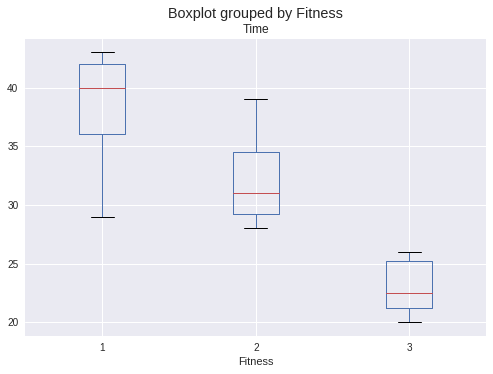

In [7]:
# Make a box-and-whisker plot from Pandas DataFrame
"""
The box extends from the Q1 to Q3 quartile values of the data, with a line
at the median (Q2). The whiskers extend from the edges of box to show the 
range of the data. 

The position of the whiskers is set by default to 1.5 * IQR (IQR = Q3 - Q1)
from the edges of the box. 

Outlier points are those past the end of the whiskers.
"""
boxplot = rehab_data.boxplot('Time', by='Fitness')
plt.show()

# Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html

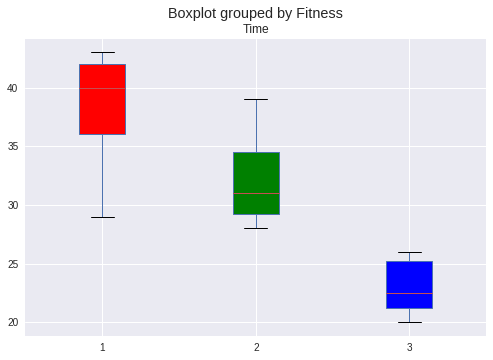

In [8]:
# to fill the colors inside the box
bp_dict = rehab_data.boxplot("Time",
    by="Fitness", 
    return_type='both',
    patch_artist = True,
)

colors = ['red', 'green', 'blue']
for row_key, (ax,row) in bp_dict.iteritems():
    ax.set_xlabel('')
    for i,box in enumerate(row['boxes']):
        box.set_facecolor(colors[i])

plt.show()
# Source: https://stackoverflow.com/questions/50963960/change-color-of-individual-boxes-in-pandas-boxplot-subplots

violin plots from seaborn - not in the original R notebook

"A violin plot plays a similar role as a box and whisker plot. It shows the distribution of quantitative data across several levels of one (or more) categorical variables such that those distributions can be compared. Unlike a box plot, in which all of the plot components correspond to actual datapoints, the violin plot features a kernel density estimation of the underlying distribution."  

"This can be an effective and attractive way to show multiple distributions of data at once, but keep in mind that the estimation procedure is influenced by the sample size, and violins for relatively small samples might look misleadingly smooth."

Source: https://seaborn.pydata.org/generated/seaborn.violinplot.html

/home/doojung/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/home/doojung/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


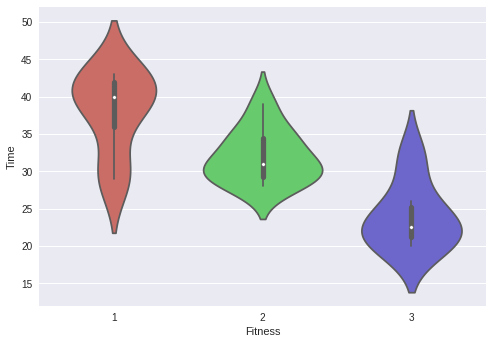

In [9]:
sns.violinplot(x="Fitness", y="Time", data=rehab_data, palette="hls")
plt.show()

## One-way ANOVA

*   First generalization of two sample $t$-test: more than two groups.

* Observations are broken up into $r$ groups with $n_i, 1 \leq i \leq r$ observations per group. 

*  Model:
    $$Y_{ij} = \mu  + \alpha_i + \varepsilon_{ij}, \qquad \varepsilon_{ij} \overset{IID}{\sim} N(0, \sigma^2).$$

*   Constraint: $\sum_{i=1}^r \alpha_i = 0$. This constraint is needed
    for "identifiability". This is "equivalent" to only adding $r-1$
    columns to the design matrix for this qualitative variable.
 

## One-way ANOVA

* This is not the same *parameterization* we get when only adding $r-1$ 0-1 columns, but it gives the same *model*.

* The estimates of $\alpha$ can be obtained from the estimates
of $\beta$ using `R`'s default parameters.

* For a more detailed exploration into `R`'s creation of design matrices,
try reading the following [tutorial on design matrices](http://nbviewer.ipython.org/github/fperez/nipy-notebooks/blob/master/exploring_r_formula.ipynb).

## Remember, it's still a model (i.e. a plane)

<img src="http://stats191.stanford.edu/figs/axes_multiple_full.svg"  width="700">


## Fitting the model


-   Model is easy to fit:
    $$\widehat{Y}_{ij} = \frac{1}{n_i} \sum_{j=1}^{n_i} Y_{ij} = \overline{Y}_{i\cdot}$$
    If observation is in $i$-th group: predicted mean is just the sample
    mean of observations in $i$-th group.

-   Simplest question: is there any group (main) effect?
 $$H_0:\alpha_1 = \dots = \alpha_r= 0?$$

-   Test is based on $F$-test with full model vs. reduced model. Reduced
    model just has an intercept.

-   Other questions: is the effect the same in groups 1 and 2?
    $$H_0:\alpha_1=\alpha_2?$$


In [10]:
formula_oneway_anova = 'Time ~ C(Fitness)'
rehab_res = ols(formula_oneway_anova, data=rehab_data).fit()
rehab_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Time   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     16.96
Date:                Wed, 19 Jun 2019   Prob (F-statistic):           4.13e-05
Time:                        21:41:24   Log-Likelihood:                -68.286
No. Observations:                  24   AIC:                             142.6
Df Residuals:                      21   BIC:                             146.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          38.0000      1.574     24.149      0.000      34.728      41.272
C(Fitness)[T.2]    -6.0000      2.111     -2.842      0.010     -10.390      -1.610
C(Fitness)[T.3]   -14.0000      2.404     -5.824      0.000     -18.999      -9.001
==============================================================================
Omnibus:                        0.163   Durbin-Watson:                   2.209
Prob(Omnibus):                  0.922   Jarque-Bera (JB):                0.211
Skew:                          -0.163   Prob(JB):                        0.900
Kurtosis:                       2.675   Cond. No.                         3.80
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
#prepare the data for prediction
predict_data = pd.DataFrame([1, 2, 3], columns=["Fitness"])
predict_data 

,Fitness
0,1
1,2
2,3


In [12]:
rehab_res.predict(exog=predict_data)

0    38.0
1    32.0
2    24.0
dtype: float64

In [13]:
pd.concat([rehab_data[rehab_data["Fitness"] == 1].mean(),
         rehab_data[rehab_data["Fitness"] == 2].mean(),
         rehab_data[rehab_data["Fitness"] == 3].mean()], axis=1)

,0,1,2
Fitness,1.0,2.0,3.0
Time,38.0,32.0,24.0


Recall that the rows of the `Coefficients` table above do not
correspond to the $\alpha$ parameter. For one thing, we would see 
three $\alpha$'s and their sum would have to be equal to 0.

Also, the design matrix is the indicator coding we saw last time.


In [14]:
pd.DataFrame(rehab_res.model.exog, columns=rehab_res.model.exog_names).head(6)

,Intercept,C(Fitness)[T.2],C(Fitness)[T.3]
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0


* There are ways to get *different* design matrices by using the
`contrasts` argument. This is a bit above our pay grade at the moment.

* Upon inspection of the design matrix above, we see that
the `(Intercept)` coefficient corresponds to the mean in `Fitness==1`, while
`Fitness==2` coefficient corresponds to the difference between the groups 
`Fitness==2` and `Fitness==1`.

In [15]:
# to see
print("Intercept      : ", rehab_res.params[0])
print("group Fitness1 : ", rehab_data[rehab_data["Fitness"] == 1].mean())
print("\n")
print("C(Fitness)[T.2]: ", rehab_res.params[1])
print("group Fitness2 - Fitness1", rehab_data[rehab_data["Fitness"] == 2].mean() 
                              - rehab_data[rehab_data["Fitness"] == 1].mean())

Intercept      :  38.0
group Fitness1 :  Fitness     1.0
Time       38.0
dtype: float64


C(Fitness)[T.2]:  -5.999999999999995
group Fitness2 - Fitness1 Fitness    1.0
Time      -6.0
dtype: float64


## ANOVA table

Much of the information in an ANOVA model is contained in the 
ANOVA table.

<table>
<tr><td>Source</td><td width="300">SS</td><td width="100">df</td><td width="100">$\mathbb{E}(MS)$</td></tr>
<tr><td>Treatment</td><td>$SSTR=\sum_{i=1}^r n_i \left(\overline{Y}_{i\cdot} - \overline{Y}_{\cdot\cdot}\right)^2$</td><td>r-1</td><td>$\sigma^2 + \frac{\sum_{i=1}^r n_i \alpha_i^2}{r-1}$</td></tr>
<tr><td>Error</td><td>$SSE=\sum_{i=1}^r \sum_{j=1}^{n_i}(Y_{ij} - \overline{Y}_{i\cdot})^2$</td>
<td>$\sum_{i=1}^r (n_i - 1)$</td><td>$\sigma^2$</td></tr>
</table>

In [16]:
anova_rehab = anova_lm(rehab_res)
anova_rehab

,df,sum_sq,mean_sq,F,PR(>F)
C(Fitness),2.0,672.0,336.000000,16.961538,0.000041
Residual,21.0,416.0,19.809524,NaN,NaN


-   Note that $MSTR$ measures â€œvariabilityâ€ of the â€œcellâ€ means. If
    there is a group effect we expect this to be large relative to
    $MSE$.

-   We see that under $H_0:\alpha_1=\dots=\alpha_r=0$, the expected
    value of $MSTR$ and $MSE$ is $\sigma^2$. This tells us how to test
    $H_0$ using ratio of mean squares, i.e. an $F$ test.



## Testing for any main effect


-   Rows in the ANOVA table are, in general, independent.

-   Therefore, under $H_0$
    $$F = \frac{MSTR}{MSE} = \frac{\frac{SSTR}{df_{TR}}}{\frac{SSE}{df_{E}}} \sim F_{df_{TR}, df_E}$$
    the degrees of freedom come from the $df$ column in previous table.

-   Reject $H_0$ at level $\alpha$ if
    $F > F_{1-\alpha, df_{TR}, df_{E}}.$


In [17]:
# MSTR/MSE
F = 336.00 / 19.81
F

16.96113074204947

In [18]:
anova_rehab.F

C(Fitness)    16.961538
Residual            NaN
Name: F, dtype: float64

In [19]:
anova_rehab.df

C(Fitness)     2.0
Residual      21.0
Name: df, dtype: float64

In [20]:
pval = 1 - stats.f.cdf(F, anova_rehab.df.values[0], anova_rehab.df.Residual)

In [21]:
d = dict(F=F, pval=pval)
pd.DataFrame(d, columns=["F", "pval"], index=[0])

,F,pval
0,16.961131,0.000041


## Inference for linear combinations

- Suppose we want to "infer" something about
   $$                                                                           
   \sum_{i=1}^r a_i \mu_i$$
   where $\mu_i = \mu+\alpha_i$ is the mean in the $i$-th group.
   For example:
   $$
   H_0:\mu_1-\mu_2=0 \qquad \text{(same as $H_0:\alpha_1-\alpha_2=0$)}?$$       
- For example:

    Is there a difference between below average and average groups in 
    terms of rehab time?                                                                      

## Inference for linear combinations


- We need to know $$
   \text{Var}\left(\sum_{i=1}^r a_i \overline{Y}_{i\cdot} \right) = \sigma^2 
   \sum_{i=1}^r \frac{a_i^2}{n_i}.$$
   
- After this, the usual confidence intervals and $t$-tests apply.

In [22]:
pd.DataFrame(rehab_res.model.exog, columns=rehab_res.model.exog_names).head(6)

,Intercept,C(Fitness)[T.2],C(Fitness)[T.3]
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0


This means that the coefficient Fitness2 is the estimated
   difference between the two groups.

## Two-way ANOVA

Often, we will have more than one variable we are changing.

### Example

After kidney failure, we suppose that the time of stay in hospital depends on weight gain between treatments and duration of treatment. 

We will model the `log` number of days as a function of the other
two factors.

<table>
<tr><td><b>Variable</b></td><td><b>Description</b></td></tr>
<tr><td>Days</td><td>Duration of hospital stay</td></tr>
<tr><td>Weight</td><td>How much weight is gained?</td></tr>
<tr><td>Duration</td><td>How long under treatment for kidney problems? (two levels)</td></tr>
</table>


In [23]:
filepath = os.path.join(os.path.curdir, 'data', 'kidney.csv')
kidney_data = pd.read_csv(filepath)
kidney_data["logDays"] = np.log(kidney_data["Days"] + 1)
kidney_data.head(6)

,Days,Duration,Weight,ID,logDays
0,0.0,1,1,1,0.000000
1,2.0,1,1,2,1.098612
2,1.0,1,1,3,0.693147
3,3.0,1,1,4,1.386294
4,0.0,1,1,5,0.000000
5,2.0,1,1,6,1.098612


In [24]:
factor_D = pd.Categorical(kidney_data.Days)
factor_D

[0.0, 2.0, 1.0, 3.0, 0.0, ..., 15.0, 4.0, 9.0, 6.0, 1.0]
Length: 60
Categories (18, float64): [0.0, 1.0, 2.0, 3.0, ..., 20.0, 25.0, 27.0, 30.0]

In [25]:
factor_W = pd.Categorical(kidney_data.Weight)
factor_W

[1, 1, 1, 1, 1, ..., 3, 3, 3, 3, 3]
Length: 60
Categories (3, int64): [1, 2, 3]

### Two-way ANOVA model

-   Second generalization of $t$-test: more than one grouping variable.

-   Two-way ANOVA model: 
    - $r$ groups in first factor
    - $m$ groups in second factor
    - $n_{ij}$ in each combination of factor variables.

- Model: 
    $$Y_{ijk} = \mu + \alpha_i + \beta_j + (\alpha \beta)_{ij} +         
    \varepsilon_{ijk} , \qquad \varepsilon_{ijk} \sim N(0, \sigma^2).$$

-   In kidney example, $r=3$ (weight gain), $m=2$ (duration of
    treatment), $n_{ij}=10$ for all $(i,j)$.


### Questions of interest


Two-way ANOVA: main questions of interest

-   Are there main effects for the grouping variables?
    $$H_0:\alpha_1 = \dots = \alpha_r = 0, \qquad H_0: \beta_1 = \dots = \beta_m = 0.$$

-   Are there interaction effects:
    $$H_0:(\alpha\beta)_{ij} = 0, 1 \leq i \leq r, 1 \leq j \leq m.$$

### Interactions between factors

We've already seen these interactions in the IT salary example. 

- An *additive model* says that the effects of the two factors
occur additively -- such a model has no interactions.

- An *interaction* is present whenever the additive model does not hold.

### Interaction plot

When these broken lines are not parallel, there is evidence of an interaction.
The one thing missing from this plot are errorbars. The above broken lines
are clearly not parallel but there is measurement error. If the
error bars were large then we might consider there to be no interaction, otherwise we might.

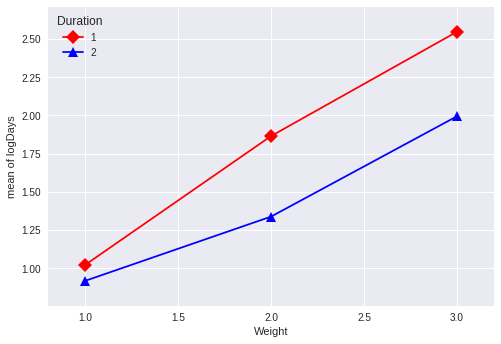

In [26]:
# Interaction plot for factor level statistics.
interaction_plot(x=kidney_data["Weight"], 
                trace=kidney_data["Duration"], 
                response=kidney_data["logDays"],
                colors=['red','blue'], 
                markers=['D','^'],
                markersize=10, 
                ax=plt.gca())
plt.ylabel("mean of logDays")
plt.show()

### Parameterization

-   Many constraints are needed, again for identifiability. Letâ€™s not
    worry too much about the details

-   Constraints:

    -   $\sum_{i=1}^r \alpha_i = 0$

    -   $\sum_{j=1}^m \beta_j = 0$

    -   $\sum_{j=1}^m (\alpha\beta)_{ij} = 0, 1 \leq i \leq r$

    -   $\sum_{i=1}^r (\alpha\beta)_{ij} = 0, 1 \leq j \leq m.$

- We should convince ourselves that we know have exactly $r*m$ free parameters.

### Fitting the model

-   Easy to fit when $n_{ij}=n$ (balanced)
    $$\widehat{Y}_{ijk}= \overline{Y}_{ij\cdot} = \frac{1}{n}\sum_{k=1}^{n} Y_{ijk}.$$

-   Inference for combinations
    $$\text{Var} \left(\sum_{i=1}^r \sum_{j=1}^m a_{ij} \overline{Y}_{ij\cdot}\right) = \frac{ \sigma^2}{n} \cdot \sum_{i=1}^r \sum_{j=1}^m{a_{ij}^2}.$$

-   Usual $t$-tests, confidence intervals.

In [27]:
# Wrong: not having contrasts in the formula
formula_no_contrasts = 'logDays ~ C(Duration) * C(Weight)'
kidney_res_no_contrasts = ols(formula=formula_no_contrasts, 
                             data=kidney_data).fit()
kidney_res_no_contrasts.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logDays   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     7.431
Date:                Wed, 19 Jun 2019   Prob (F-statistic):           2.30e-05
Time:                        21:41:25   Log-Likelihood:                -63.314
No. Observations:                  60   AIC:                             138.6
Df Residuals:                      54   BIC:                             151.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           1.0212      0.232      4.407      0.000       0.557       1.486
C(Duration)[T.2]                   -0.1042      0.328     -0.318      0.752      -0.761       0.553
C(Weight)[T.2]                      0.8439      0.328      2.575      0.013       0.187       1.501
C(Weight)[T.3]                      1.5271      0.328      4.661      0.000       0.870       2.184
C(Duration)[T.2]:C(Weight)[T.2]    -0.4231      0.463     -0.913      0.365      -1.352       0.506
C(Duration)[T.2]:C(Weight)[T.3]    -0.4491      0.463     -0.969      0.337      -1.378       0.480
==============================================================================
Omnibus:                        7.659   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                2.856
Skew:                          -0.168   Prob(JB):                        0.240
Kurtosis:                       1.985   Cond. No.                         9.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Contrasts Overview - not in the original notebook
Source: https://www.statsmodels.org/dev/examples/notebooks/generated/contrasts.html

"A categorical variable of K categories, or levels, usually enters a regression as a sequence of K-1 dummy variables. This amounts to a linear hypothesis on the level means. That is, each test statistic for these variables amounts to testing whether the mean for that level is statistically significantly different from the mean of the base category. This dummy coding is called Treatment coding in R parlance, and we will follow this convention. There are, however, different coding methods that amount to different sets of linear hypotheses.

In fact, the dummy coding is not technically a contrast coding. This is because the dummy variables add to one and are not functionally independent of the model's intercept. On the other hand, a set of contrasts for a categorical variable with k levels is a set of k-1 functionally independent linear combinations of the factor level means that are also independent of the sum of the dummy variables. The dummy coding isn't wrong per se. It captures all of the coefficients, but it complicates matters when the model assumes independence of the coefficients such as in ANOVA. Linear regression models do not assume independence of the coefficients and thus dummy coding is often the only coding that is taught in this context"

#### Sum (Deviation) Coding - not in the original notebook

"Sum coding compares the mean of the dependent variable for a given level to the overall mean of the dependent variable over all the levels"

Source: https://www.statsmodels.org/dev/examples/notebooks/generated/contrasts.html

In [28]:
# Correct: Having contrasts in the formula
from patsy.contrasts import Sum
levels=[0, 1]
contrast = Sum().code_without_intercept(levels)
print(contrast.matrix)

[[ 1.]
 [-1.]]


In [29]:
formula_contrasts = "logDays ~ C(Duration, Sum) * C(Weight, Sum)"
res_contrasts = ols(formula=formula_contrasts, 
                      data=kidney_data).fit()
res_contrasts.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logDays   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     7.431
Date:                Wed, 19 Jun 2019   Prob (F-statistic):           2.30e-05
Time:                        21:41:25   Log-Likelihood:                -63.314
No. Observations:                  60   AIC:                             138.6
Df Residuals:                      54   BIC:                             151.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     1.6140      0.095     17.063      0.000       1.424       1.804
C(Duration, Sum)[S.1]                         0.1975      0.095      2.088      0.042       0.008       0.387
C(Weight, Sum)[S.1]                          -0.6450      0.134     -4.821      0.000      -0.913      -0.377
C(Weight, Sum)[S.2]                          -0.0126      0.134     -0.095      0.925      -0.281       0.256
C(Duration, Sum)[S.1]:C(Weight, Sum)[S.1]    -0.1454      0.134     -1.087      0.282      -0.414       0.123
C(Duration, Sum)[S.1]:C(Weight, Sum)[S.2]     0.0662      0.134      0.495      0.623      -0.202       0.334
==============================================================================
Omnibus:                        7.659   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                2.856
Skew:                          -0.168   Prob(JB):                        0.240
Kurtosis:                       1.985   Cond. No.                         1.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Example

* Suppose we are interested in comparing the mean in $(D=1,W=3)$ and $(D=2,W=2)$
groups. The difference is
$$
E(\bar{Y}_{13\cdot}-\bar{Y}_{22\cdot})
$$

* By independence, its variance is 
$$\text{Var}(\bar{Y}_{13\cdot}) + \text{Var}(\bar{Y}_{22\cdot}) = \frac{2 \sigma^2}{n}.
$$

In [30]:
new_point = dict(intercept=1, Duration=1, Weight=3)
new_point2 = dict(intercept=1, Duration=2, Weight=2)
new_data = pd.DataFrame([new_point, new_point2])

In [31]:
Y_hat = res_contrasts.predict(new_data)

In [32]:
fit = Y_hat[0]-Y_hat[1]
print(fit)

1.210551391615516


In [33]:
# another way to get prediction mean
predictions = res_contrasts.get_prediction(exog=new_data)

In [34]:
predictions.summary_frame(alpha=0.05)["mean"]

0    2.548271
1    1.337719
Name: mean, dtype: float64

In [35]:
# residual standard error = positive square root of the mean square error
sigma_hat = np.sqrt(res_contrasts.mse_resid)

In [36]:
# ten observations per group
n = 10
tppf = stats.t.ppf(1 - (0.05/2.0), res_contrasts.df_resid)
upper = fit + tppf * np.sqrt(2 * sigma_hat**2 / n)
lower = fit - tppf * np.sqrt(2 * sigma_hat**2 / n)

In [37]:
print("fit   : ", fit)
print("lower : ", lower)
print("uppder: ", upper)

fit   :  1.210551391615516
lower :  0.553613296680555
uppder:  1.8674894865504768


In [38]:
pd.DataFrame(res_contrasts.model.exog, columns=res_contrasts.model.exog_names).head(6)

,Intercept,"C(Duration, Sum)[S.1]","C(Weight, Sum)[S.1]","C(Weight, Sum)[S.2]","C(Duration, Sum)[S.1]:C(Weight, Sum)[S.1]","C(Duration, Sum)[S.1]:C(Weight, Sum)[S.2]"
0,1.0,1.0,1.0,0.0,1.0,0.0
1,1.0,1.0,1.0,0.0,1.0,0.0
2,1.0,1.0,1.0,0.0,1.0,0.0
3,1.0,1.0,1.0,0.0,1.0,0.0
4,1.0,1.0,1.0,0.0,1.0,0.0
5,1.0,1.0,1.0,0.0,1.0,0.0


### Finding predicted values

The most direct way to compute predicted values is using the `predict` function


In [39]:
# another way to get prediction mean
new_point3 = dict(intercept=1, Duration=1, Weight=1)
new_data2 = pd.DataFrame([new_point3])
predictions2 = res_contrasts.get_prediction(exog=new_data2)

In [40]:
predictions2.summary_frame(alpha=0.05)
# R produces mean_ci_lower and mean_ci_upper

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,1.021156,0.231697,0.556631,1.485681,-0.5195,2.561812


### ANOVA table

In the balanced case, everything can again be summarized
from the ANOVA table

<table>
<tr><td>Source</td><td width="400">SS</td><td width="100">df</td><td width="200">$\mathbb{E}(MS)$</td></tr>
<tr><td>A</td><td>$SSA=nm\sum_{i=1}^r  \left(\overline{Y}_{i\cdot\cdot} - \overline{Y}_{\cdot\cdot\cdot}\right)^2$</td><td>r-1</td><td>$\sigma^2 + nm\frac{\sum_{i=1}^r \alpha_i^2}{r-1}$</td></tr>
<tr><td>B</td><td>$SSB=nr\sum_{j=1}^m  \left(\overline{Y}_{\cdot j\cdot} - \overline{Y}_{\cdot\cdot\cdot}\right)^2$</td>
<td>m-1</td><td>$\sigma^2 + nr\frac{\sum_{j=1}^m \beta_j^2}{m-1}$</td></tr>
<tr><td>A:B</td><td>$SSAB = n\sum_{i=1}^r \sum_{j=1}^m  \left(\overline{Y}_{ij\cdot} - \overline{Y}_{i\cdot\cdot} - \overline{Y}_{\cdot j\cdot} + \overline{Y}_{\cdot\cdot\cdot}\right)^2$</td>
<td>(m-1)(r-1)</td><td>$\sigma^2 + n\frac{\sum_{i=1}^r\sum_{j=1}^m (\alpha\beta)_{ij}^2}{(r-1)(m-1)}$</td></tr>
<tr><td>Error</td><td>$SSE = \sum_{i=1}^r \sum_{j=1}^m \sum_{k=1}^{n}(Y_{ijk} - \overline{Y}_{ij\cdot})^2$</td>
<td>(n-1)mr</td><td>$\sigma^2$</td></tr>
</table>


### Tests using the ANOVA table

* Rows of the ANOVA table can be used to test various
of the hypotheses we started out with.

* For instance, we see that under
  $H_0:(\alpha\beta)_{ij}=0, \forall i,j$ the expected value of $SSAB$
  and $SSE$ is $\sigma^2$ â€“ use these for an $F$-test testing for an
  interaction.
  
- Under $H_0$
    $$F = \frac{MSAB}{MSE} = \frac{\frac{SSAB}{(m-1)(r-1)}}{\frac{SSE}{(n-1)mr}} \sim F_{(m-1)(r-1), (n-1)mr}$$


In [41]:
anova_lm(res_contrasts)

,df,sum_sq,mean_sq,F,PR(>F)
"C(Duration, Sum)",1.0,2.339693,2.339693,4.358293,0.041562
"C(Weight, Sum)",2.0,16.971291,8.485645,15.806745,0.000004
"C(Duration, Sum):C(Weight, Sum)",2.0,0.635658,0.317829,0.592040,0.556748
Residual,54.0,28.989198,0.536837,NaN,NaN


We can also test for interactions using our usual approach


In [42]:
# one-liner as in R
anova_lm(ols("logDays ~ C(Duration) + C(Weight)", data=kidney_data).fit(), 
         res_contrasts)

/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,56.0,29.624856,0.0,NaN,NaN,NaN
1,54.0,28.989198,2.0,0.635658,0.59204,0.556748


### Some caveats about `R` formulae

While we see that it is straightforward to form the
interactions test using our usual `anova` function approach, we generally
*cannot* test for main effects by this approach. 


In [43]:
res_no_main_weight = ols("logDays ~ C(Duration) + C(Weight):C(Duration)", 
                         data=kidney_data).fit()
anova_lm(res_no_main_weight, res_contrasts)

/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,54.0,28.989198,0.0,NaN,NaN,NaN
1,54.0,28.989198,-0.0,-3.552714e-15,inf,NaN


In [44]:
anova_lm(ols("logDays ~ C(Duration)", data=kidney_data).fit(),
        ols("logDays ~ C(Duration) + C(Weight)", data=kidney_data).fit())

/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,58.0,46.596147,0.0,NaN,NaN,NaN
1,56.0,29.624856,2.0,16.971291,16.040454,0.000003


In fact, these models are identical in terms of their *planes* or their
*fitted values*. What has happened is that `R` has
formed a different design matrix using its rules for `formula` objects.

In [45]:
res_1 = ols("logDays ~ C(Duration) + C(Weight):C(Duration)", 
            data=kidney_data).fit()
res_2 = ols("logDays ~ C(Duration) + C(Weight):C(Duration) + C(Weight)", 
            data=kidney_data).fit()

print(np.sum((res_1.resid - res_2.resid)**2))
assert (np.abs(np.sum((res_1.resid - res_2.resid)**2)) < 0.0000001)
# no diff

9.890343599208436e-29



## ANOVA tables in general

So far, we have used `anova` to compare two models. In this section,
we produced tables for just 1 model. This also works for
*any* regression model, though we have to be a little careful
about interpretation.

Let's revisit the job aptitude test data from last section.


In [46]:
url = 'http://stats191.stanford.edu/data/jobtest.table'
jobtest_data = pd.read_table(url)
print(jobtest_data.head())
jobtest_formula = "JPERF ~ TEST:C(MINORITY) + C(MINORITY) + TEST"
jobtest_res = ols(jobtest_formula, data=jobtest_data).fit()
jobtest_res.summary()

/home/doojung/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  from ipykernel import kernelapp as app


   TEST  MINORITY  JPERF
0  0.28         1   1.83
1  0.97         1   4.59
2  1.25         1   2.97
3  2.46         1   8.14
4  2.51         1   8.00


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  JPERF   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     10.55
Date:                Wed, 19 Jun 2019   Prob (F-statistic):           0.000451
Time:                        21:41:27   Log-Likelihood:                -32.971
No. Observations:                  20   AIC:                             73.94
Df Residuals:                      16   BIC:                             77.92
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.0103      1.050      1.914      0.074      -0.216       4.236
C(MINORITY)[T.1]         -1.9132      1.540     -1.242      0.232      -5.179       1.352
TEST                      1.3134      0.670      1.959      0.068      -0.108       2.735
TEST:C(MINORITY)[T.1]     1.9975      0.954      2.093      0.053      -0.026       4.021
==============================================================================
Omnibus:                        3.377   Durbin-Watson:                   3.015
Prob(Omnibus):                  0.185   Jarque-Bera (JB):                1.330
Skew:                           0.120   Prob(JB):                        0.514
Kurtosis:                       1.760   Cond. No.                         13.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now, let's look at the `anova` output. We'll see the results don't match.



In [47]:
anova_lm(jobtest_res)

,df,sum_sq,mean_sq,F,PR(>F)
C(MINORITY),1.0,8.051805,8.051805,4.069719,0.060756
TEST,1.0,45.917904,45.917904,23.208829,0.000189
TEST:C(MINORITY),1.0,8.666073,8.666073,4.380196,0.052650
Residual,16.0,31.655473,1.978467,NaN,NaN


The difference is how the `Sum Sq` columns is created. In the `anova` output, terms in the
response are added sequentially.

We can see this by comparing these two models directly. The `F` statistic doesn't agree
because the `MSE` above is computed in the *fullest* model, but the `Sum of Sq` is correct.


In [48]:
anova_lm(ols("JPERF ~ TEST", data=jobtest_data).fit(),
        ols("JPERF ~ TEST + C(MINORITY)", data=jobtest_data).fit())

/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,18.0,45.568297,0.0,NaN,NaN,NaN
1,17.0,40.321546,1.0,5.246751,2.212087,0.155246


Similarly, the first `Sum Sq` in `anova` can be found by:



In [49]:
anova_lm(ols("JPERF ~ 1", data=jobtest_data).fit(),
        ols("JPERF ~ TEST", data=jobtest_data).fit())

/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/doojung/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,19.0,94.291255,0.0,NaN,NaN,NaN
1,18.0,45.568297,1.0,48.722958,19.246127,0.000356


There are ways to produce an *ANOVA* table whose $p$-values agree with
`summary`. This is done by an ANOVA table that uses Type-III sum of squares.


In [50]:
anova_lm(jobtest_res, typ=3)
# Source: http://www.statsmodels.org/devel/generated/statsmodels.stats.anova.anova_lm.html

,sum_sq,df,F,PR(>F)
Intercept,7.250560,1.0,3.664736,0.073633
C(MINORITY),3.052180,1.0,1.542699,0.232115
TEST,7.594407,1.0,3.838531,0.067749
TEST:C(MINORITY),8.666073,1.0,4.380196,0.052650
Residual,31.655473,16.0,NaN,NaN


In [51]:
jobtest_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  JPERF   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     10.55
Date:                Wed, 19 Jun 2019   Prob (F-statistic):           0.000451
Time:                        21:41:27   Log-Likelihood:                -32.971
No. Observations:                  20   AIC:                             73.94
Df Residuals:                      16   BIC:                             77.92
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.0103      1.050      1.914      0.074      -0.216       4.236
C(MINORITY)[T.1]         -1.9132      1.540     -1.242      0.232      -5.179       1.352
TEST                      1.3134      0.670      1.959      0.068      -0.108       2.735
TEST:C(MINORITY)[T.1]     1.9975      0.954      2.093      0.053      -0.026       4.021
==============================================================================
Omnibus:                        3.377   Durbin-Watson:                   3.015
Prob(Omnibus):                  0.185   Jarque-Bera (JB):                1.330
Skew:                           0.120   Prob(JB):                        0.514
Kurtosis:                       1.760   Cond. No.                         13.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Fixed and random effects

-   In kidney & rehab examples, the categorical variables are
    well-defined categories: below average fitness, long duration, etc.

-   In some designs, the categorical variable is "subject".

-   Simplest example: repeated measures, where more than one (identical)
    measurement is taken on the same individual.

-   In this case, the "group" effect $\alpha_i$ is best thought of as
    random because we only sample a subset of the entire population.



### When to use random effects?

-   A "group" effect is random if we can think of the levels we observe
    in that group to be samples from a larger population.

-   Example: if collecting data from different medical centers, "center"
    might be thought of as random.

-   Example: if surveying students on different campuses, "campus" may
    be a random effect.



### Example: sodium content in beer

-   How much sodium is there in North American beer? How much does this
    vary by brand?

-   Observations: for 6 brands of beer, we recorded the sodium content
    of 8 12 ounce bottles.

-   Questions of interest: what is the â€œgrand meanâ€ sodium content? How
    much variability is there from brand to brand?

-   â€œIndividualsâ€ in this case are brands, repeated measures are the 8
    bottles.


In [52]:
filepath = os.path.join(os.path.curdir, 'data', 'sodium.csv')
sodium_data = pd.read_csv(filepath)
sodium_data.head(6)

,sodium,brand,bottle
0,24.4,1,1
1,22.6,1,2
2,23.8,1,3
3,22.0,1,4
4,24.5,1,5
5,22.3,1,6


In [53]:
anova_lm(ols("sodium ~ C(brand)", data=sodium_data).fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(brand),5.0,854.529167,170.905833,238.711174,1.083746e-29
Residual,42.0,30.070000,0.715952,NaN,NaN


In [54]:
factor_brand = pd.Categorical(sodium_data.brand)
factor_brand

[1, 1, 1, 1, 1, ..., 6, 6, 6, 6, 6]
Length: 48
Categories (6, int64): [1, 2, 3, 4, 5, 6]

### One-way random effects model

-   Assuming that cell-sizes are the same, i.e. equal observations for
    each â€œsubjectâ€ (brand of beer).

-   Observations
    $$Y_{ij} \sim \mu+ \alpha_i + \varepsilon_{ij}, 1 \leq i \leq r, 1 \leq j \leq n$$

-   $\varepsilon_{ij} \sim N(0, \sigma^2_{\epsilon}), 1 \leq i \leq r, 1 \leq j \leq n$

-   $\alpha_i \sim N(0, \sigma^2_{\alpha}), 1 \leq  i \leq r.$

-   Parameters:

    -   $\mu$ is the population mean;

    -   $\sigma^2_{\epsilon}$ is the measurement variance (i.e. how variable are
        the readings from the machine that reads the sodium content?);

    -   $\sigma^2_{\alpha}$ is the population variance (i.e. how variable
	is the sodium content of beer across brands).

### Modelling the variance

- In random effects model, the observations are no longer independent (even if $\varepsilon$'s are independent
   $$                                                                                                                                         
   {\rm Cov}(Y_{ij}, Y_{i'j'}) = \left(\sigma^2_{\alpha}  + \sigma^2_{\epsilon} \delta_{j,j'} \right) \delta_{i,i'}.$$

- In more complicated models, this makes ``maximum likelihood estimation'' more complicated: least squares is no longer the best solution. 

- **It's no longer just a plane!**


- This model has a very simple model for the *mean*, it just has a slightly
more complex model for the *variance*.

- Shortly we'll see other more complex models of the variance:
    - Weighted Least Squares
    - Correlated Errors

### Fitting the model

The *MLE (Maximum Likelihood Estimator)* is found by minimizing
$$
\begin{aligned}
-2 \log \ell (\mu, \sigma^2_{\epsilon}, \sigma^2_{\alpha}|Y) &= \sum_{i=1}^r \biggl[ (Y_i - \mu)^T (\sigma^2_{\epsilon} I_{n_i \times n_i} + \sigma^2_{\alpha} 11^T)^{-1} (Y_i - \mu) \\
& \qquad + \log \left( \det(\sigma^2_{\epsilon} I_{n_i \times n_i} + \sigma^2_{\alpha} 11^T) \right) \biggr].
\end{aligned}
$$

THe function $\ell(\mu, \sigma^2_{\epsilon}, \sigma^2_{\alpha})$ is called the *likelihood function*.

### Fitting the model in balanced design

Only one parameter in the mean function $\mu.$
- When cell sizes are the same (balanced),
   $$                                                                           
   \widehat{\mu} = \overline{Y}_{\cdot \cdot} = \frac{1}{nr} \sum_{i,j} Y_{ij}.$$
Unbalanced models: use numerical optimizer.

- This also changes estimates of $\sigma^2_{\epsilon}$ -- see ANOVA table. We
 might guess that $df=nr-1$ and
   $$                                                                           
   \widehat{\sigma}^2 = \frac{1}{nr-1} \sum_{i,j} (Y_{ij} - \overline{Y}_{\cdot\cdot})^2.$$
   **This is not correct.**

### ANOVA table

Again, the information needed can be summarized in an
ANOVA table.

<table>
<tr><td>Source</td><td width="300">SS</td><td width="100">df</td><td width="100">$\mathbb{E}(MS)$</td></tr>
<tr><td>Treatment</td><td>$SSTR=\sum_{i=1}^r n_i \left(\overline{Y}_{i\cdot} - \overline{Y}_{\cdot\cdot}\right)^2$</td><td>r-1</td><td>$\sigma^2_{\epsilon} + n \sigma^2_{\alpha}$</td></tr>
<tr><td>Error</td><td>$SSE=\sum_{i=1}^r \sum_{j=1}^{n_i}(Y_{ij} - \overline{Y}_{i\cdot})^2$</td>
<td>$\sum_{i=1}^r (n_i - 1)$</td><td>$\sigma^2_{\epsilon}$</td></tr>
</table>

- ANOVA table is still useful to setup tests: the same $F$ statistics for fixed or random will work here.

- Test for random effect: $H_0:\sigma^2_{\alpha}=0$ based on
   $$
   F = \frac{MSTR}{MSE} \sim F_{r-1, (n-1)r} \qquad \text{under $H_0$}.$$


### Degrees of freedom

- Why $r-1$ degrees of freedom?
 
- Imagine we could record an infinite number of observations for each individual, so that $\overline{Y}_{i\cdot} \rightarrow \mu + \alpha_i$.

- To learn anything about $\mu_{\cdot}$ we still only have $r$ observations
   $(\mu_1, \dots, \mu_r)$.

- Sampling more within an individual cannot narrow the CI for $\mu$.


### Inference for $\mu$

- Easy to check that
   $$
   \begin{aligned}
   E(\overline{Y}_{\cdot \cdot}) &= \mu   \\
   \text{Var}(\overline{Y}_{\cdot \cdot}) &= \frac{\sigma^2_{\epsilon} + n\sigma^2_{\alpha}}{rn}.
   \end{aligned}
   $$

- To come up with a $t$ statistic that we can use for test, CIs, we
   need to find an estimate of $\text{Var}(\overline{Y}_{\cdot \cdot})$.
  
  
- ANOVA table says $E(MSTR) = n\sigma^2_{\alpha}+\sigma^2_{\epsilon}$ which suggests
   $$                                                                           
   \frac{\overline{Y}_{\cdot \cdot} - \mu_{\cdot}}{\sqrt{\frac{MSTR}{rn}}} \sim t_{r-1}.$$

### Estimating $\sigma^2_{\alpha}$

We have seen estimates of $\mu$ and $\sigma^2_{\epsilon}$. Only one parameter
remains.

- Based on the ANOVA table, we see that
$$
\sigma^2_{\alpha} =  \frac{1}{n}(\mathbb{E}(MSTR) - \mathbb{E}(MSE)).
$$

- This suggests the estimate
$$
\hat{\sigma^2}_{\alpha} = \frac{1}{n} (MSTR-MSE).
$$

- However, this estimate can be negative!

- Many such computational difficulties arise in random (and mixed) effects models.




## Mixed effects model

- The one-way random effects ANOVA is a special case of a so-called *mixed effects* model:
$$
\begin{aligned}
Y_{n \times 1} &= X_{n \times p}\beta_{p \times 1} + Z_{n \times q}\gamma_{q \times 1} \\
\gamma &\sim N(0, \Sigma).
\end{aligned}
$$

- Various models also consider restrictions on $\Sigma$ (e.g. diagonal, unrestricted, block diagonal, etc.)


- Our multiple linear regression model is a (very simple) mixed-effects model with $q=n$, 
$$
\begin{aligned}
Z &= I_{n \times n} \\
\Sigma &= \sigma^2 I_{n \times n}.
\end{aligned}
$$

## Using mixed effects models: `lme`


Source: http://www.statsmodels.org/stable/mixed_linear.html  
Example: http://www.statsmodels.org/stable/examples/notebooks/generated/mixed_lm_example.html  
MixedLM.from_formula: http://www.statsmodels.org/devel/generated/statsmodels.regression.mixed_linear_model.MixedLM.from_formula.html

In [55]:
from statsmodels.formula.api import mixedlm

Not in the original notebook ...

In [56]:
# First we fit a model that expresses 
# the mean sodium as a linear function of brand, 
# with a random intercept for each brand. 
sodium_mixedlm = mixedlm("sodium ~ C(brand)", 
                         data=sodium_data,
                         groups=sodium_data["brand"]).fit()
sodium_mixedlm.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM    Dependent Variable:    sodium  
No. Observations:     48         Method:                REML    
No. Groups:           6          Scale:                 0.7160  
Min. group size:      8          Likelihood:            -58.8168
Max. group size:      8          Converged:             Yes     
Mean group size:      8.0                                       
----------------------------------------------------------------
               Coef.    Std.Err.      z    P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept      23.638        0.897  26.338 0.000  21.878  25.397
C(brand)[T.2] -12.963        1.269 -10.213 0.000 -15.450 -10.475
C(brand)[T.3]  -4.300        1.269  -3.388 0.001  -6.788  -1.812
C(brand)[T.4]  -6.138        1.269  -4.836 0.000  -8.625  -3.650
C(brand)[T.5]  -9.425        1.269  -7.426 0.000 -11.913  -6.937
C(brand)[T.6]  -3.225        1.269  -2.541 0.011  -5.713  -0.737
Group Var       0.716 28391736.809                              
================================================================

"""

in the original R notebook, but not generating exactly same result...

In [57]:
sodium_mixedlm = mixedlm("sodium ~ 1", 
                         data=sodium_data,
                         groups=sodium_data["brand"]).fit()
sodium_mixedlm.summary()

# mixedLMResult
# Source: https://www.statsmodels.org/devel/generated/statsmodels.regression.mixed_linear_model.MixedLMResults.html

<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: sodium  
No. Observations: 48      Method:             REML    
No. Groups:       6       Scale:              0.7160  
Min. group size:  8       Likelihood:         -74.4615
Max. group size:  8       Converged:          Yes     
Mean group size:  8.0                                 
------------------------------------------------------
             Coef.  Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    17.629    1.887 9.344 0.000 13.931 21.327
Group Var    21.267   16.880                          
======================================================

"""

In [58]:
sodium_mixedlm.params

Intercept    17.629167
Group Var    29.702890
dtype: float64

In [59]:
sodium_mixedlm.tvalues # 9.342733

Intercept    9.344274
Group Var    1.488898
dtype: float64

In [60]:
sodium_mixedlm.pvalues #0

Intercept    9.252227e-21
Group Var    1.365141e-01
dtype: float64

In [61]:
sodium_mixedlm.bse #1.886939 - slightly different from the original notebook

Intercept     1.886628
Group Var    19.949575
dtype: float64

In [62]:
# the standard errors of the fixed effect regression coefficients.
sodium_mixedlm.bse_fe

Intercept    1.886628
dtype: float64

**WARNING**  
The following result is different from the original R notebook

In [63]:
# WARNING!!!
# does not match with the original R notebook
sodium_mixedlm.conf_int(alpha=0.05)

,0,1
Intercept,13.931444,21.326889
Group Var,-9.397559,68.803338


For reasons I'm not sure of, the degrees of freedom don't agree with our ANOVA, though we do find the correct SE for our estimate of μ:

In [64]:
sodium_mixedlm.df_resid

47

In [65]:
# anova_lm(sodium_mixedlm) 
# throws an AttributeError: 'MixedLMResults' object has no attribute 'ssr'

The intervals formed by `lme` use the 42 degrees of freedom, but 
are otherwise the same:

**WARNING**  
The following result is different from the original R notebook

In [66]:
center = sodium_data.sodium.mean()
center

17.629166666666663

In [67]:
tppf = stats.t.ppf(1 - (0.05/2.0), sodium_mixedlm.df_resid)
upper = center + tppf * sodium_mixedlm.bse_fe["Intercept"]
lower = center - tppf * sodium_mixedlm.bse_fe["Intercept"]

In [68]:
print("lower", upper)
print("upper", lower)

lower 21.42457226318537
upper 13.833761070147954



Using our degrees of freedom as 5 yields slightly wider intervals


In [69]:
tppf = stats.t.ppf(1 - (0.05/2.0), 5)
upper = center + tppf * sodium_mixedlm.bse_fe["Intercept"]
lower = center - tppf * sodium_mixedlm.bse_fe["Intercept"]

In [70]:
print("lower", upper)
print("upper", lower)

lower 22.478897851276372
upper 12.779435482056954


** FUTURE TODO:**  
follow this to understand how statsmodels' LME works:   http://www.statsmodels.org/stable/examples/notebooks/generated/mixed_lm_example.html